# analyze_histos.ipynb
---
Performs a high-level analysis using the ROOT output files from `qaqc_jig`'s `analyze-waveforms`.

The input ROOT files have the single photoelectron and source spectra histograms for each channel of the test module(s). The source could be sodium-22, cesium-137, or cobalt-57.
Another option for the source is the intrinsic radiation of LYSO, however it is unlikely that we will be using the instrinsic radiation for testing during production (this notebooks is not well tested with LYSO).

## Notes
notes here

---
## todo
general:
- [ ] find `OVER_VOLTAGE` using file name
- [ ] find `TRIG_THRESH` using file name
- [ ] find `SOURCE` using file name

plots:
- [ ] crosstalk? (needs premade histogram)

data:

misc:
- [ ] Add `VtrigXXX` to file name?

In [1]:
%reset -f

# ******************************** #
# * Default Imports & Parameters * #
# ******************************** #
import os
import sys
import matplotlib.pyplot as plt
import csv
#print(sys.path)
# **************** #
# Add module_testing to system path (can this be done in env.sh?)
# Is there a better way to do this? 
# would os.getcwd().split('/module_testing')[0]+'/module_testing' work?
# or maybe add to the env.sh 'MODULE_TESTING_DIR=$PWD'
#UNAME = os.uname()[1]
'''
UNAME = 'Alex'
if UNAME == 'psimmerl-S7P':
    UNAME, BASE_DIR = 'S7P', '/home/psimmerl/module_testing'
elif UNAME == 'psimmerl-LAU248':
    UNAME, BASE_DIR = 'LAU248', '/home/psimmerl/module_testing'
elif UNAME == 'localhost.localdomain':
    UNAME, BASE_DIR = 'CPTLAB', '/home/cptlab/module_testing'
elif UNAME == 'Alex':
    UNAME, BASE_DIR = 'Alex', '/Users/alexander_albert/Documents/BTL_Work/code/module_testing'
# elif UNAME == 'localhost.localdomain':
#     UNAME, BASE_DIR = 'TIER2', '~/module_testing'
else:
    raise ValueError(f'{UNAME=} was unexpected')
'''
BASE_DIR = '/Users/alexander_albert/Documents/BTL_Work/code/module_testing'
print(BASE_DIR)
sys.path.append(f'{BASE_DIR}')
sys.path.append(f'{BASE_DIR}/src')

# **************** #
import json
import pickle
import pathlib

import math
import numpy as np
import numba as nb

from math import ceil, floor

# **************** #
import ROOT as rt

from ROOT import TFile, TNtuple, TTree, RDataFrame
from ROOT import TCanvas, TLegend, TLatex, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors
from ROOT import TF1, TMath

ROOT_ERROR_LEVEL = {'QUIET':1001,'NORMAL':None,'VERBOSE':None}['QUIET']
ROOT_BATCH = True #! this should be true

rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
rt.gROOT.SetBatch(ROOT_BATCH)
# tdrStyle.setTDRStyle()
rt.gStyle.SetOptFit(0)
rt.gStyle.SetOptStat(0)

gc = [] # ROOT Garbage Collector
# **************** #
from src import tdrStyle

from src.helpers import alert, divide, land, lor, lnot, lxor

STD_COLOR_LIST = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]
TOP_MARGIN, BOT_MARGIN = 0.05, 0.05
TPAD_WIDTH,TPAD_HEIGHT = 800, 800
TLATEX_TEXT_SIZE = 0.04
TLEGEND_TEXT_SIZE = 0.04

/Users/alexander_albert/Documents/BTL_Work/code/module_testing
Welcome to JupyROOT 6.28/12


In [2]:
#main directory, and where to put plots! DON'T FORGET '/' AT END!
BASE_DIR = '/Users/alexander_albert/Documents/BTL_Work/code/module_testing/' #may need to change!
sys.path.append(f'{BASE_DIR}')
sys.path.append(f'{BASE_DIR}/src')
PLOT_DIR = BASE_DIR+f'notebooks/plots/calibrationTests/fixed_ch5/' #wherever you want!
pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)

In [3]:
#more globals
FIT_GAMMAS = True   
OVER_VOLTAGE = None #2.2
TRIG_VOLTAGE = None
ATTENUATION_FACTOR = 5.85
CHANNELS, BARS = np.arange(0,32), np.arange(0, 16)
SOURCES = ['spe', 'sodium', 'cesium', 'cobalt']#, 'lyso]
# SOURCES = {'lyso': None, 'sodium': 511, 'cesium': 662, 'cobalt': 122}
SOURCE_ENERGY_FIT_PAR_IDXS = {
    'spe': (1, 3, 5),
    'lyso': (1, 3, 5),
    'sodium': (511, 0, 1),
    'cesium': (662, 0, 1),
    'cobalt': (122, 0, 1)
} # E (keV), fit mu idx, fit sig idx

In [4]:
def load_data_function(run: str):
    print("Generating Module Dictionary for Data at: ", run)
    
    RUN = run
    
    DATA_DIR = BASE_DIR+f'/data/{RUN}'
    
    # **************** #
    
    print(32*'-')
    print('Starting analyze_histos.ipynb')
    #print(f'\t{UNAME=}')
    print(f'\t{RUN=}')
    print(f'\t{DATA_DIR=}')
    print(f'\t{FIT_GAMMAS=}')

    modules = [] # treat like a dataframe where each entry is a module run
    for fname in os.listdir(DATA_DIR):
        # skip anything that isn't our ROOT files and skip the weird zombie ZoneIdentifier files
        print(fname)
        if '.root' != fname[-5:] or 'ZoneIdentifier' in fname or 'RDF' in fname:
            continue
    
        # extract module test parameters
        # module_id_Vov[over voltage in V]_Vtt[trigger voltage in mV]_Nspe[num spe per trigger group]_N[source][num src per trigger group].root
        source = [s for s in SOURCES if s in fname][-1] # 0 is spe (always there)
        if source == 'spe':
            continue
    
        # print(source)
        info = fname.replace('.root','').split('_')
        module = {
            'fname' : fname,
            'tfile' : TFile(F'{DATA_DIR}/{fname}'),
            'id' : info[1],
            'source' : source,
            'vov' : float(info[2][3:]), # V
            #'vtt' : float(info[3][3:]), # mV
            'n_spe' : int(info[3][3+1:]),
            'n_source' : int(info[4][1+len(source):]),
            'spe_charge': np.zeros((32,2), dtype=float), # channels x (val, err)
            'source_charge': np.zeros((32,2), dtype=float), # channels x (val, err)
        }
        module['tfile_keys'] = [k.GetName() for k in module['tfile'].GetListOfKeys()]
    
        if 'R' in module['id'] or 'old' in module['id']:
        # if 'old' in module['id']:
            continue
    
        # apply module selections
        # skip lyso (not used in production -> we won't take data for it)
        # TODO: would be nice if figure out lyso, but don't spend too much time
        if (source in ('lyso',)) or \
            (isinstance(OVER_VOLTAGE, (int, float)) and OVER_VOLTAGE != module['vov']) or \
            (isinstance(TRIG_VOLTAGE, (int, float)) and TRIG_VOLTAGE != module['vtt']):
            continue
    
        # Extract Channel SPE & Source Charges
        for s in ('spe', 'source'):
            eng, iAve, iErr = SOURCE_ENERGY_FIT_PAR_IDXS[s if s == 'spe' else source]
            for ch in CHANNELS:
                k = f'{s if s == "spe" else source}_ch{ch}_fit'
                if k not in module['tfile_keys']:
                    print(f'Module {module["id"]} missing {s} fit for ch{ch}')
                    continue
                tfit = module['tfile'].Get(k)
                # print(tfit.GetFormula())
                # a0 = 1 if 'spe' == s else eng*ATTENUATION_FACTOR # if source, then convert from pC/keV to pC
                a0 = 1 if 'spe' == s else 1000*ATTENUATION_FACTOR # if source, then convert from pC/keV to pC/MeV
                qave, qerr = a0*tfit.GetParameter(iAve), a0*tfit.GetParError(iAve)
                # if iErr != iAve:
                #     qerr = tfit.GetParameter(iErr)/eng*a0
                # print(f'{s=}, {ch=}, {qave=}, {qerr=}')
                module[f'{s}_charge'][ch] = [qave, qerr]
    
        modules.append(module)
        print(f'Loaded Module {module["id"]}:')
        print(f'\t{module["fname"]=}')
        # print(f'\t{module["tfile"]=}')
        print(f'\t{module["id"]=}')
        print(f'\t{module["source"]=}')
        print(f'\t{module["vov"]=}')
        #print(f'\t{module["vtt"]=}')
        print(f'\t{module["n_spe"]=}')
        print(f'\t{module["n_source"]=}')
        # print(f'\t{module["spe_charge"]=}')
        # print(f'\t{module["source_charge"]=}')
        print('')
    
    print(f'Loaded {len(modules)} modules')
    
    return modules

In [5]:
modules_AA = load_data_function('calibrationTests/fixed_ch5/AA/')
modules_AB = load_data_function('calibrationTests/fixed_ch5/AB/')

Generating Module Dictionary for Data at:  calibrationTests/fixed_ch5/AA/
--------------------------------
Starting analyze_histos.ipynb
	RUN='calibrationTests/fixed_ch5/AA/'
	DATA_DIR='/Users/alexander_albert/Documents/BTL_Work/code/module_testing//data/calibrationTests/fixed_ch5/AA/'
	FIT_GAMMAS=True
module_100025_Vov2.00_Nspe100000_Nsodium200000.root
Loaded Module 100025:
	module["fname"]='module_100025_Vov2.00_Nspe100000_Nsodium200000.root'
	module["id"]='100025'
	module["source"]='sodium'
	module["vov"]=2.0
	module["n_spe"]=100000
	module["n_source"]=200000

module_100026_Vov2.00_Nspe100000_Nsodium200000.root
Loaded Module 100026:
	module["fname"]='module_100026_Vov2.00_Nspe100000_Nsodium200000.root'
	module["id"]='100026'
	module["source"]='sodium'
	module["vov"]=2.0
	module["n_spe"]=100000
	module["n_source"]=200000

module_200042B_Vov2.00_Nspe100000_Nsodium200000.root
Loaded Module 200042B:
	module["fname"]='module_200042B_Vov2.00_Nspe100000_Nsodium200000.root'
	module["id"]='2

In [6]:
# Some helper functions

def fix_yrange(hmin, hmax):
    if hmin - 5*BOT_MARGIN*(hmax-hmin) < 0:
        hmin, hmax = 0, hmax + TOP_MARGIN*hmax
    else: # this doesn't do what I want
        mult = (1 + BOT_MARGIN + TOP_MARGIN) * (hmax - hmin)
        hmin, hmax = hmin - BOT_MARGIN*mult, hmax + TOP_MARGIN*mult
    return hmin, hmax



# Spectra



In [7]:
def gaus(x, mu=0, sig=1):
        return 1/(sig*(2*math.pi)**0.5) * math.exp(-0.5*((x-mu)/sig)**2)

In [8]:
def fit_gamma(hist, pol=2):
    #print("entering fit gamma")
    '''gaussian + polynomial background'''
    def bc(bin):
        return hist.GetBinCenter(bin)
    def bv(x):
        return hist.GetBinContent(hist.FindBin(x))

    old_chisq = hist.GetListOfFunctions()[-1].GetChisquare()
    # print(f', {old_chisq}',end='') # @FIT_X2
    NS = 2
    for i in range(3):
        if i == 0:
            # bin = 0;       underflow bin
            # bin = 1;       first bin with low-edge xlow INCLUDED
            # bin = nbins;   last bin with upper-edge xup EXCLUDED
            # bin = nbins+1; overflow bin
            centers = np.array([hist.GetBinCenter(ibin) for ibin in range(1, hist.GetNbinsX())])
            content = np.array([hist.GetBinContent(ibin) for ibin in range(1, hist.GetNbinsX())])
            A, mu = 0, 0
            for ic, (ce, co) in enumerate(zip(centers[::-1], content[::-1])):
                if ic < 10:
                    continue
                # co_ave10, ce_ave10 = np.mean(content[::-1][ic-5:ic+5]), np.mean(centers[::-1][ic-5:ic+5])
                # co_ave10, ce_ave10 = np.mean(content[::-1][ic-10:ic+10]), np.mean(centers[::-1][ic-10:ic+10])
                # if co_ave10 > A and co_ave10 > np.mean(content):
                #     mu, A = ce_ave10, co_ave10
                # if mu and co_ave10 < A*3/4:
                #     break
                left = np.mean(content[::-1][ic:ic+15])
                right = np.mean(content[::-1][ic-15:ic])
                center = np.mean(content[::-1][ic-5:ic+5])
                if center > left and center > right and center > np.mean(content) and abs(left-right)*2/(left+right) < 0.1:# and center > A:
                    mu, A = ce, co
                    # print(hist.GetName(), mu, A)
                    break
            # idx = np.argmax(content * (np.abs(centers-mu) < 10))
            # A, mu = content[idx], centers[idx]
            # A, mu = hist.GetMaximum(), bc(hist.GetMaximumBin())
            # A = hist.GetBinContent(int(mu))
            sig, p0, p1, p2 = 0, 0, 0, 0



        # print(f'{A=:.2f}, {mu=:.2f}, {sig=:.2f}, {p0=:.2f}, {p1=:.2f}')
        # aa = A*gaus(0)/2+p0+p1*(mu+sig*(2*math.log(2))**0.5)
        aa = A/2+p0+p1*(mu+sig*(2*math.log(2))**0.5)
        x_fwhm = bc(hist.FindLastBinAbove(aa))
        fwhm = abs((x_fwhm-mu)) * 2
        # fwhm = bc(hist.FindLastBinAbove(aa)) \
        #         - bc(hist.FindFirstBinAbove(aa,
        #                                     firstBin=hist.FindBin(mu - (1.5*(bc(hist.FindLastBinAbove(aa)) - mu))),
        #                                     lastBin=hist.GetMaximumBin()))
        sig = fwhm / (2*(2*math.log(2))**0.5)
        # if not sig:
        #     sig = mu**0.5

        # print(bv(mu),bv(mu-3*sig),bv(mu+3*sig))
        # A = gaus(0) * (bv(mu) - (bv(mu-NS*sig)+bv(mu+NS*sig))/2) / ( gaus(0) - gaus(NS) )
        A = gaus(0) * (bv(mu) - (bv(mu-NS*sig)+bv(mu+NS*sig))/2) / ( gaus(0) - gaus(NS) )
        # print(i)
        p1 = (bv(mu+NS*sig)-bv(mu-NS*sig)) / (2*NS*sig)
        p0 = bv(mu) - (A + p1*mu)
        # print(i, hist.GetName(), mu, sig, A, p0, p1)
        # print(f'{A=:.2f}, {mu=:.2f}, {sig=:.2f}, {p0=:.2f}, {p1=:.2f}')

        # hist.hh.GetListOfFunctions()[-1].SetParameter(0, A)
        # hist.hh.GetListOfFunctions()[-1].SetParameter(0, A)
    # print()

    # A *= gaus(0)
    for source in SOURCE_ENERGY_FIT_PAR_IDXS:
        if source in hist.GetName():
            eng = SOURCE_ENERGY_FIT_PAR_IDXS[source][0]
            mu /= eng
    # print(hist.GetListOfFunctions()[-1].GetFormula())
    # mu0 = hist.GetListOfFunctions()[-1].GetParameter(0)
    # sig0 = hist.GetListOfFunctions()[-1].GetParameter(1)
    # A0 = hist.GetListOfFunctions()[-1].GetParameter(2)
    # print(f'{hist.GetName()}')
    # print(f'{mu0=:.2f}, {mu=:.2f} | {(mu-mu0)/mu0=:.3f}')
    # print(f'{sig0=:.2f}, {sig=:.2f} | {(sig-sig0)/sig0=:.3f}')
    # print(f'{A0=:.2f}, {A=:.2f} | {(A-A0)/A0=:.3f}')
    # print()

    offset = 0 # also will need to fix
    fit_eq = f'[2]*exp(-0.5*(x-{offset}-[0]*{eng})**2/[1]**2) + [3] - [4]*x'# + [5]*x*x'

    # print(mu, sig, A, p0, p1)
    for i in range(3):
        xl, xh = mu*eng - NS*sig, mu*eng + NS*sig
        fit = TF1(f'{hist.GetName()}_fit{i}',fit_eq, xl, xh)
        fit.SetParLimits(0, mu*2/3, mu*4/3)
        fit.SetParLimits(1, sig*2/3, sig*4/3)
        fit.SetParLimits(2, A*2/3, A*4/3)
        # fit.SetParLimits(3, p0*2/3, p0*4/3)
        fit.SetParLimits(3, 0, p0*4/3)
        # fit.SetParLimits(4, p1*2/3, p1*4/3)
        fit.SetParLimits(4, 0, p1*4/3)

        fit.SetParameters(mu, sig, A, p0, p1)#, p2)
        # fit.SetParLimits(4, -1e999, 0)
        # fit.SetRange(xl, xh)
        hist.Fit(fit, 'QMN', '', xl, xh)
        hist.GetListOfFunctions()[-1] = fit
        mu = fit.GetParameter(0)
        sig = fit.GetParameter(1)
        A = fit.GetParameter(2)
        p0 = fit.GetParameter(3)
        p1 = fit.GetParameter(4)
        # p2 = fit.GetParameter(5)
        # print(mu*eng, sig, A, p0, p1)
    # print('\n\n')
    new_chisq = fit.GetChisquare()
    # print(f', {new_chisq}],') # @FIT_X2
    return mu, fit.GetParError(0), sig, A, p0, p1

In [9]:
def get_spectra_hists(modules):
    # Plot spectra for each module/bar
    #print("fig_gamma", fit_gamma)
    #print(type(modules))
    global hmin; global hmax; global xmin; global xmax
    global chs; global nns; global hhs; global tts; global lws; global lcs
    n_rows, n_cols = 4, 4
    canvas = TCanvas('','',TPAD_WIDTH*n_cols,TPAD_HEIGHT*n_rows)
    tlegend_coords = (0.7, 0.7, 0.97, 0.87)
    hists_legends_dict = {}
    for module in modules:
        for source in ('spe', module['source']):
            hmin, hmax, xmin, xmax = 0,0,0,0
            #print(source)
            #print(f'plotting {source} spectra for module {module["id"]}')
            canvas.Clear()
            canvas.Divide(n_cols, n_rows)
            tfile = module['tfile']
    
            ### Create Histos
            hists, legends, hmin, hmax, xmin, xmax = [], [], 1e99, -1, 1e99, -1
            for bar in BARS:
                #print("Bar: ", bar)
                chs = [bar, bar+16] # [left_ch, right_ch]
                nns = [f'Ch {ch}' for ch in chs]  # names
                hhs = [tfile.Get(f'{source}_ch{ch}') for ch in chs]  # histograms
                tts = [f'Bar {bar} {source} Response'] * len(chs)  # histogram titles
                lws = [10] * len(chs)  # histogram line widths
                lcs = [rt.kRed, rt.kAzure]  # histogram line colors
                #print(tts)
                # Make the legend for each subplot
                legend = TLegend(*tlegend_coords)
                legend.SetTextSize(TLEGEND_TEXT_SIZE)
    
                for ihh, hh in enumerate(hhs):
                    if FIT_GAMMAS and source not in ('spe','lyso'):
                        # print(f'[{chs[ihh]}', end='') # @FIT_X2
                        mu, mue, sig, A, p0, p1 = fit_gamma(hh)
                        # print(mu, sig, A, p0, p1)
                        module['source_charge'][bar+ihh*16] = [
                            # A/gaus(0) / hh.Integral(),
                            mu*1000*ATTENUATION_FACTOR,
                            mue*1000*ATTENUATION_FACTOR
                            # sig*ATTENUATION_FACTOR/SOURCE_ENERGY_FIT_PAR_IDXS[source][0]
                        ]
                        #if module['id']=='200041' and source=='sodium' and bar==0:
                        #    print(module['source_charge'][bar+ihh*16])
                        # print(A, mu, sig, p0, p1)
                    if len(hh.GetListOfFunctions()):
                        # draw the function it exists
                        hh.GetListOfFunctions()[-1].SetLineWidth(int(lws[ihh]/2))
                        hh.GetListOfFunctions()[-1].SetLineColor(rt.kMagenta)
                    hh.SetTitle(tts[ihh])
                    hh.SetName(nns[ihh])
                    hh.GetXaxis().SetTitle('Charge (pC)')
                    hh.SetLineColor(lcs[ihh])
                    hh.SetLineWidth(lws[ihh])
                    legend.AddEntry(hh, f'{nns[ihh]}', 'l')

                    hmin = 0 #min(hmin, hh.GetBinContent(hh.GetMinimumBin()))# hh.GetMinimum()) # hist max is set weird alreadyz
                    hmax = max(hmax, hh.GetBinContent(hh.GetMaximumBin()))# hh.GetMaximum()) # hist max is set weird alreadyz
                    xmin = min(xmin, hh.GetXaxis().GetXmin())
                    xmax = max(xmax, hh.GetXaxis().GetXmax())
                    #hmin, hmax = 0, hmax*1.1#fix_yrange(hmin, hmax)  # add some paddings
                    #print("hmin,hmax", hmin, hmax)
                    # update min and max if necessary
                
                hists.append(hhs)
                legends.append(legend)
            
            hists_legends_dict[module["id"], source] = (hists, legends, hmin, hmax*1.1, xmin, xmax)
    return hists_legends_dict
            


In [10]:
def draw_hist(hist_dict: dict, module: str, source: str):
    n_rows, n_cols = 4, 4
    global canvas
    canvas = TCanvas('','',TPAD_WIDTH*n_cols,TPAD_HEIGHT*n_rows)
    canvas.Divide(n_cols, n_rows)
    tlegend_coords = (0.7, 0.7, 0.97, 0.87)
    
    hists = hist_dict[module, source][0]
    legends = hist_dict[module, source][1]
    hmin = hist_dict[module, source][2]
    hmax = hist_dict[module, source][3]
    xmin = hist_dict[module, source][4]
    xmax = hist_dict[module, source][5]
    

    ### Draw
    
    for ihhs, (hhs, lg) in enumerate(zip(hists,legends)):
        canvas.cd(ihhs + 1).DrawFrame(xmin, hmin, xmax, hmax, hhs[0].GetTitle())
        canvas.cd(ihhs + 1).SetGrid()
        canvas.cd(ihhs + 1).SetRightMargin(0)
        hhs.sort(key=lambda h: h.GetXaxis().GetXmin()) # plot the hist with smaller charge first
        for ihhs, (hhs, lg) in enumerate(zip(hists,legends)):
            canvas.cd(ihhs + 1).DrawFrame(xmin, hmin, xmax, hmax, hhs[0].GetTitle())
            canvas.cd(ihhs + 1).SetGrid()
            canvas.cd(ihhs + 1).SetRightMargin(0)
            hhs.sort(key=lambda h: h.GetXaxis().GetXmin()) # plot the hist with smaller charge first
            for hh in hhs:
                # hh.GetListOfFunctions()[-1].SetLimits(xmin, xmax)
                # hh.GetXaxis().SetRangeUser(xmin, xmax)
                # hh.SetMinimum(hmin)
                # hh.SetMaximum(hmax)
                hh.Draw('same')
            lg.Draw()
    
    canvas.Draw()
        
    canvas.Print(f'{PLOT_DIR}module_{module}_{source}_spectra.png')

In [11]:
hist_dict = get_spectra_hists(modules_AA)
hist_dict_AB = get_spectra_hists(modules_AB)

/Applications/anaconda3/envs/qaqc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Applications/anaconda3/envs/qaqc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


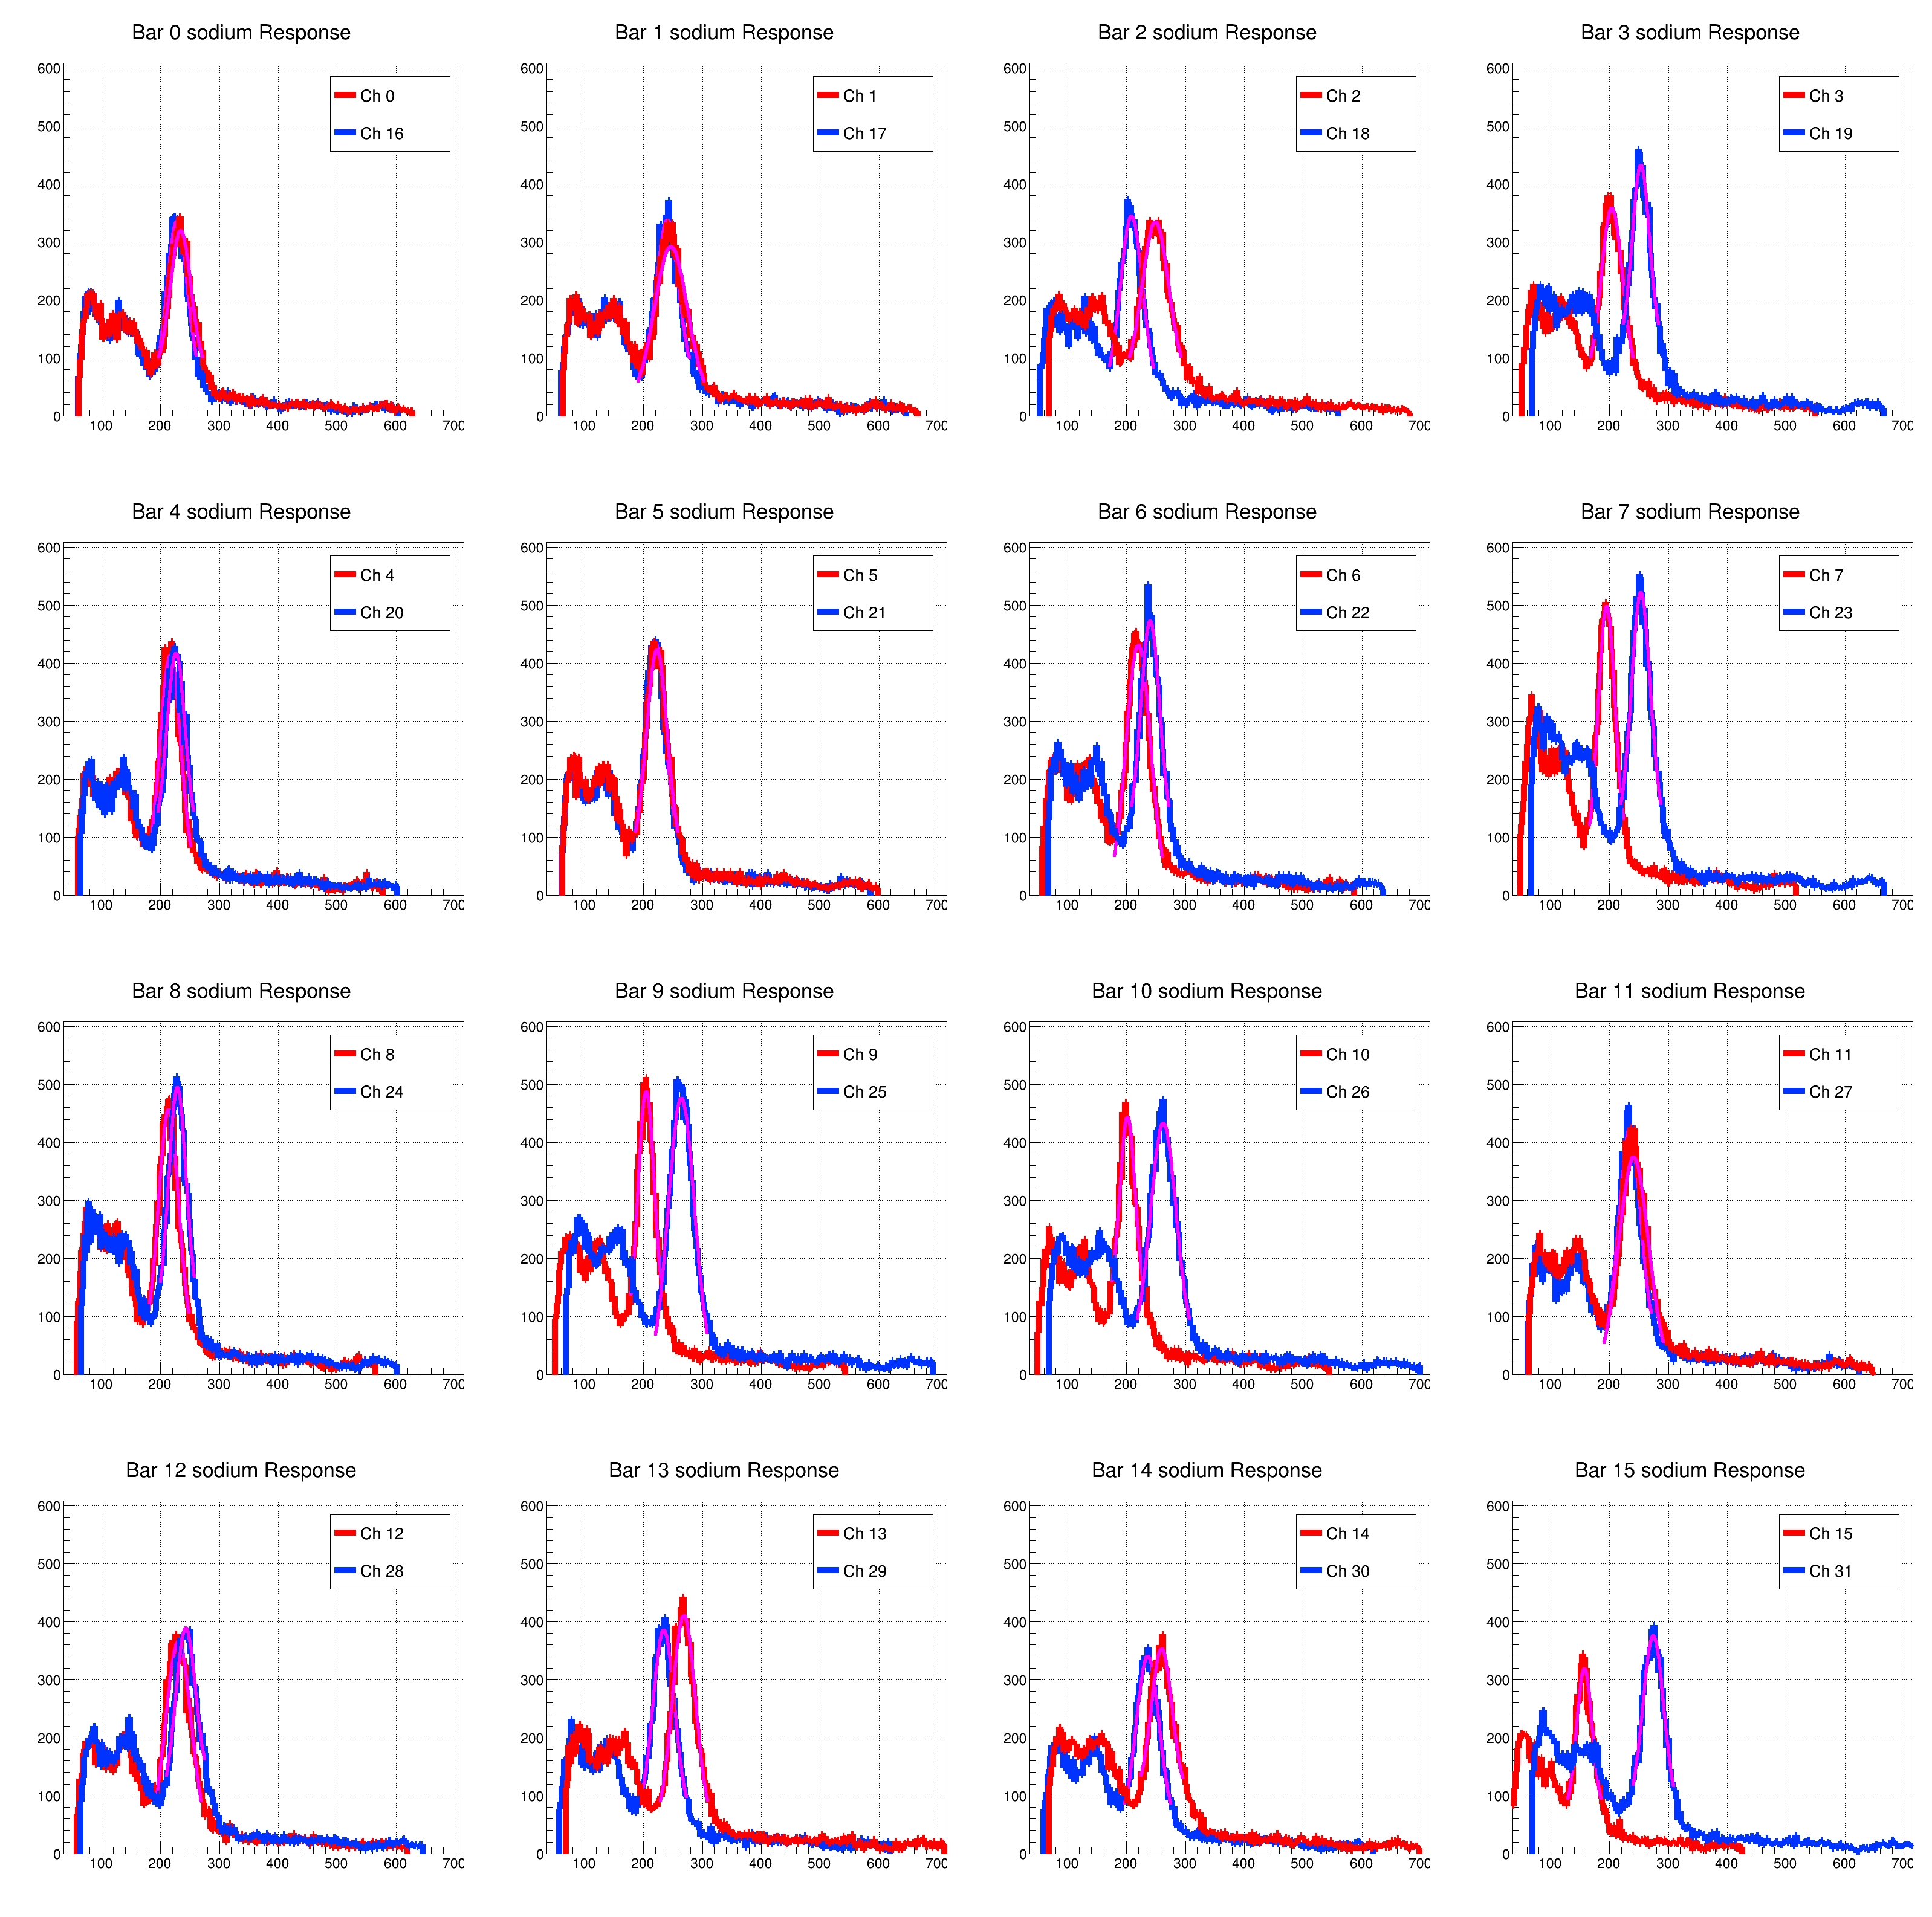

In [42]:
draw_hist(hist_dict, '100025', 'sodium')

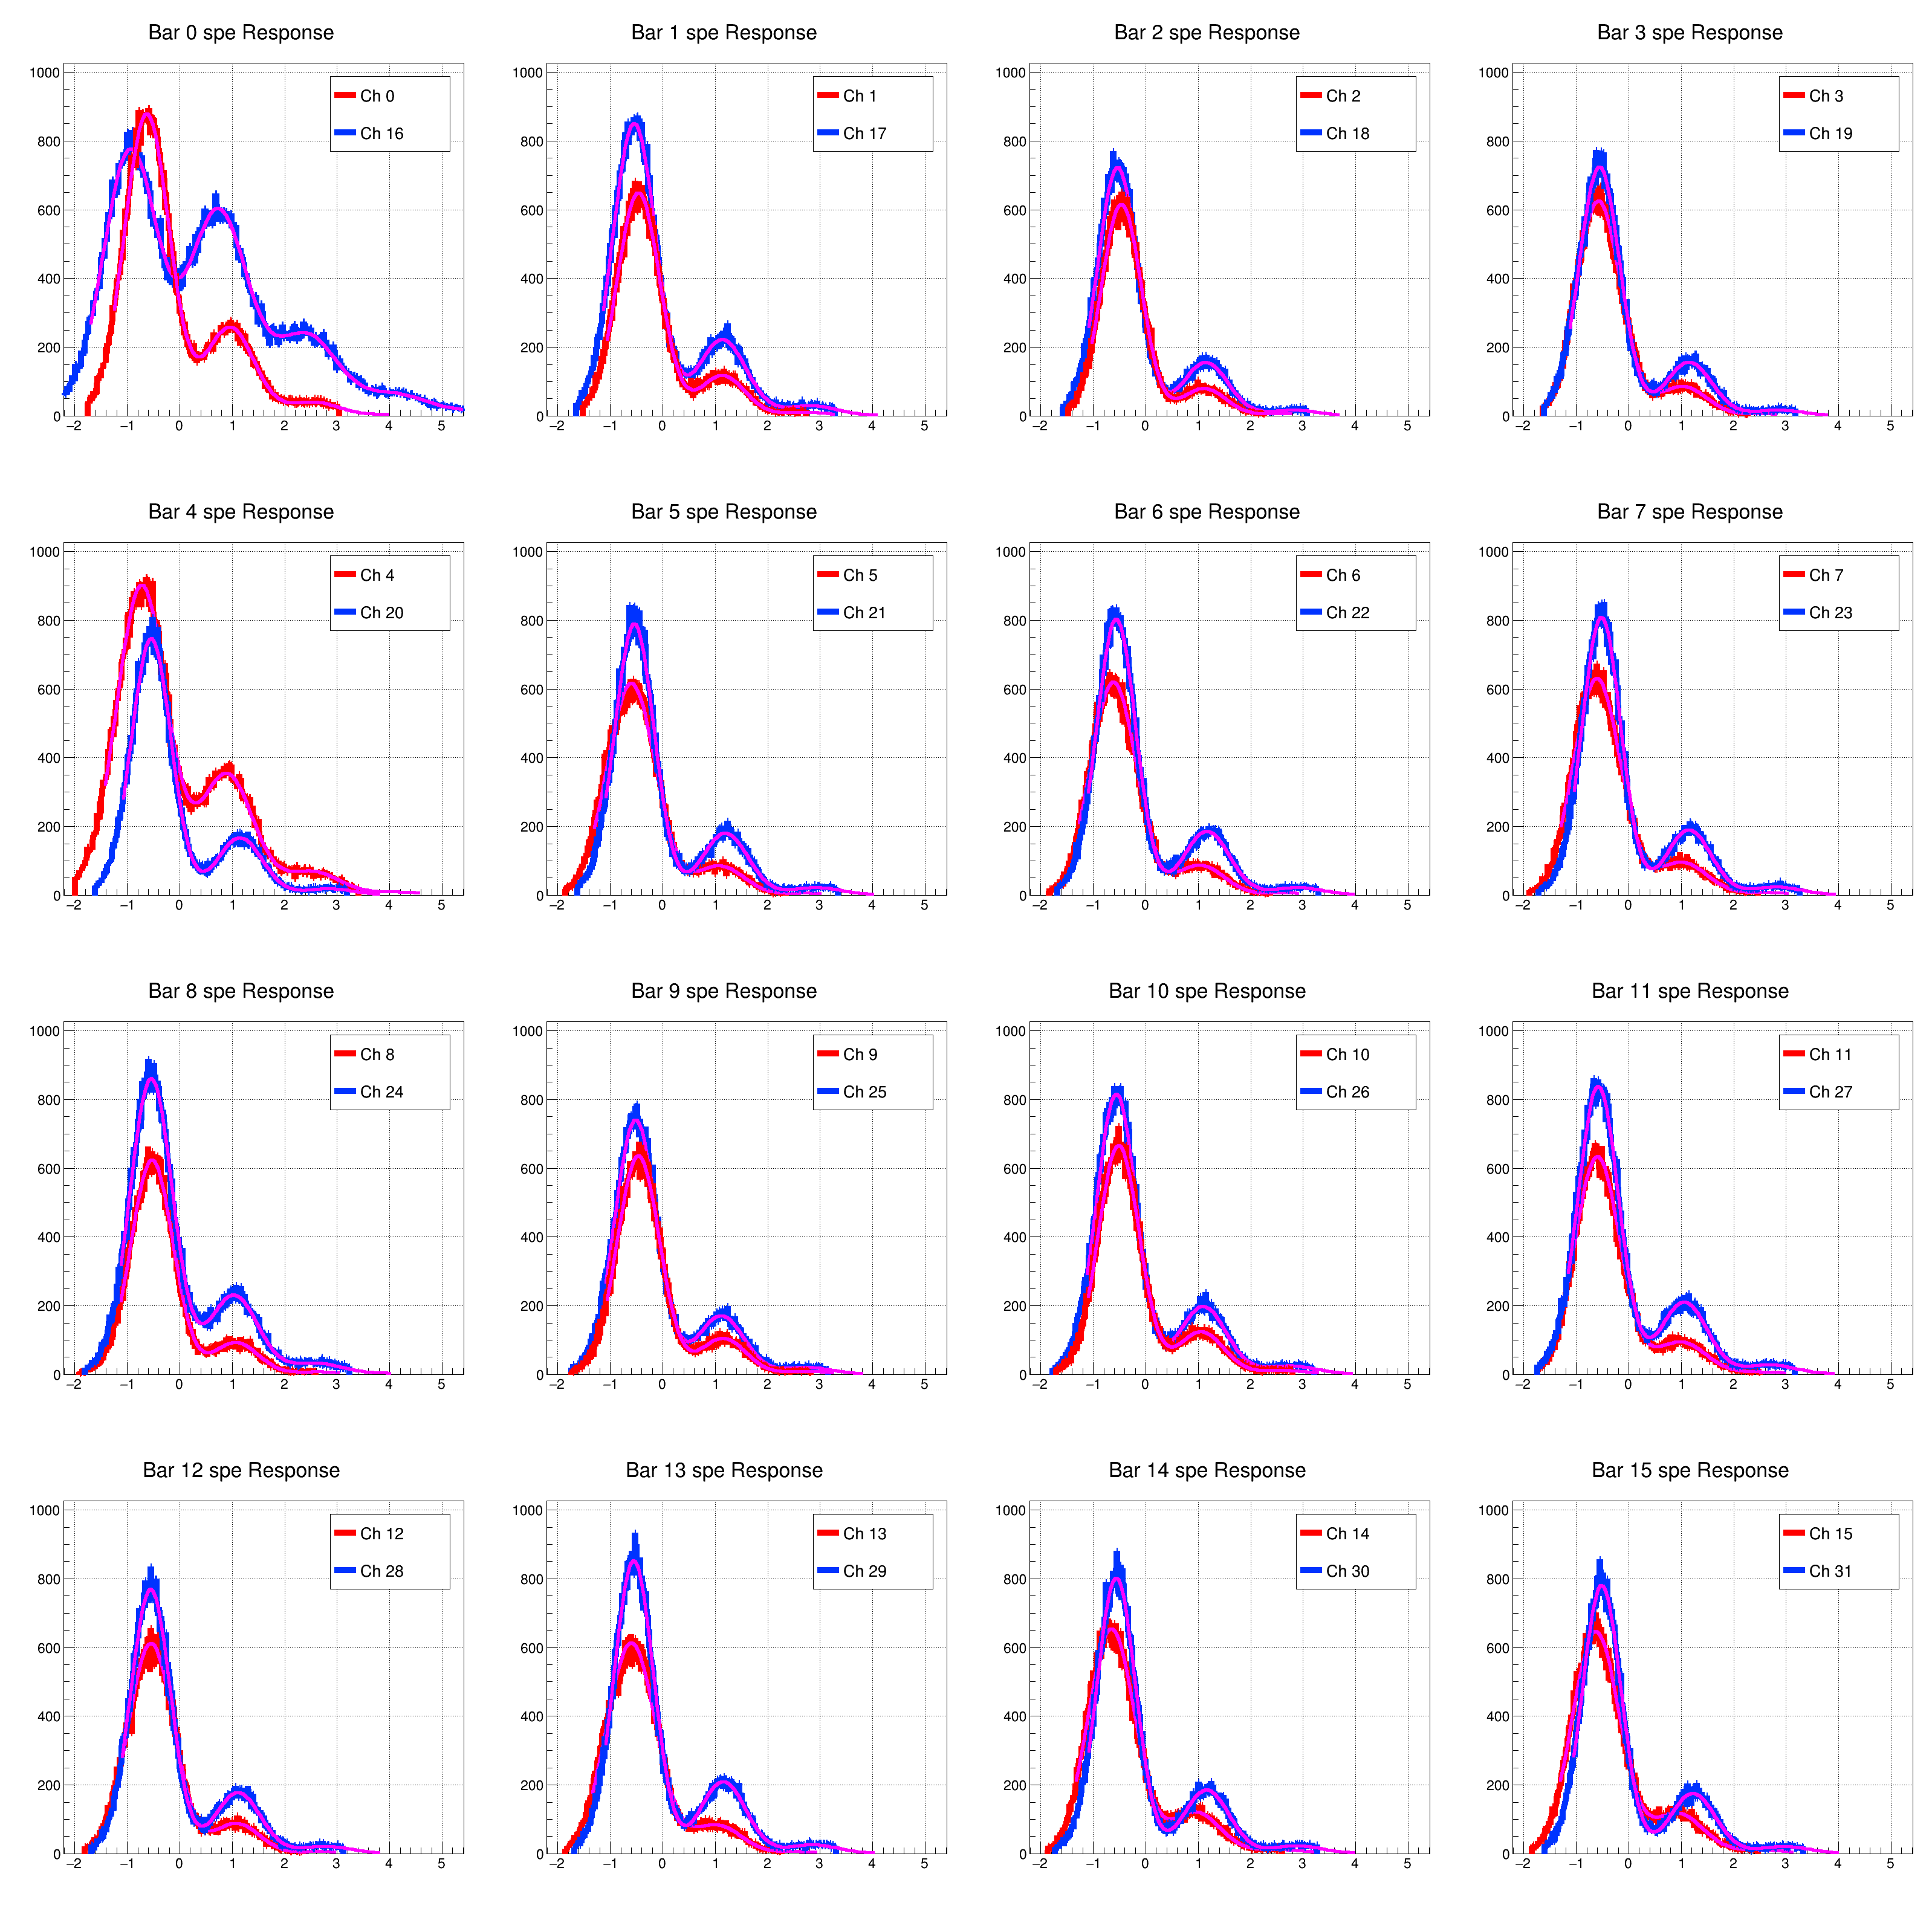

In [43]:
draw_hist(hist_dict_AB, '100025', 'spe')

# Light Yield



In [14]:
def tge_ly(ly):
    lyL, lyR = ly[:16], ly[16:]
    lyA = (lyL + lyR) / 2
    lyA[:,1] = np.sqrt( (lyL**2 + lyR**2)[:,1] ) / 2
    return [TGraphErrors(len(BARS),BARS*1.0,ly[:,0]*1.0,BARS*0.0,ly[:,1]*1.0) for ly in (lyL, lyA, lyR)]


In [15]:
# Plot light yield for each module

def plot_LY(modules, moduleName, plot_to_make, scaling=np.ones(32)):
    global canvas
    canvas = TCanvas('','',TPAD_WIDTH,TPAD_HEIGHT)
    tlegend_coords = (0.16, 0.895, 0.40, 0.74)

    vtt=25

    linearity = []
    scaling = np.stack([scaling, scaling]).T
    for moduleIter in modules:
        #print(moduleIter["id"], moduleIter["source"])
        if moduleIter["id"] == moduleName:
            module = moduleIter
    get_spectra_hists(modules)
    #print(f'plotting spe and {source} light yield for module {module["id"]}')
    ### load module info
    mid, vov, source, tfile = (module[x] for x in ('id', 'vov', 'source', 'tfile'))
    # spe charge is pC(/SPE), source charge is pC/MeV
    ly_spe, ly_src = module['spe_charge'], module['source_charge']*scaling # 32 channels x (value, errror)

    # calculate photoelectrons created by source
    # Light Yield [PE / MeV] = Source Yield [ pC / MeV ] / Single Photoelectron Yield [ pC / PE ]
    ly_pe = ly_src / ly_spe
    # ly_pe[:,1] = ly_pe[:,0] * ( (ly_spe[:,1]/ly_spe[:,0])**2 + (ly_src[:,1]/ly_src[:,0])**2 )**0.5
    ly_pe[:,1] = ly_pe[:,0] * sum([(ly[:,1]/ly[:,0])**2 for ly in (ly_spe,ly_src)])**0.5

    linearity.append([
        module['id'],
        source,
        np.mean(ly_pe[:,0][np.isfinite(ly_pe[:,0])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[:,1][np.isfinite(ly_pe[:,1])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[:16,0][np.isfinite(ly_pe[:16,0])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[:16,1][np.isfinite(ly_pe[:16,1])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[16:,0][np.isfinite(ly_pe[16:,0])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[16:,1][np.isfinite(ly_pe[16:,1])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
    ])

    ### Create Graphs
    lys = [[ly[:16],(ly[:16]+ly[16:])/2,ly[16:]] for ly in [ly_spe, ly_src, ly_pe]]
    graphs = [ tge_ly(ly) for ly in  [ly_spe, ly_src, ly_pe]]

    tt = f' Yield (Module {mid}, V_{{OV}}={vov}V, V_{{TT}}={vtt}mV)'
    titles = [ ss+tt for ss in ('SPE', f'{source.title()} Charge', f'{source.title()} Light') ]
    xlabels = ['Bar', 'Bar', 'Bar'] # x-labels
    ylabels = ['Charge Yield [pC]', 'Charge Yield [pC / MeV]', 'Light Yield [PE / MeV]'] # y-labels
    xranges = [ (-1, 16) for ly in (ly_spe, ly_src, ly_pe) ]
    yranges = [ fix_yrange(0, np.max(ly[:,0])*1.5) for ly in (ly_spe, ly_src, ly_pe) ]

    lns = ['Left (A)', 'Average', 'Right (B)'] # line names
    lws = [2,2,2] # line widths
    lcs = [rt.kRed, rt.kBlack, rt.kAzure] # line colors
    # lls = [ [f'average yield = {ly.mean():.0f} #pm {ly.std():.2f} (#pm {100*ly.std()/ly.mean():.0f}%)' for ly in [lys[:16,0],lys[16:,0],(lys[:16,0]+lys[16:,0])/2]] for lys in (ly_spe, ly_src, ly_pe) ]

    
    # plot
    if plot_to_make == "ly_spe":
        print("Making lye_spe")
        igrs=0
        grs=graphs[0]
    elif plot_to_make == "ly_src":
        print("Making lye_src")
        igrs=1
        grs=graphs[1]
    elif plot_to_make == "ly_pe":
        print("Making lye_pe")
        igrs=2
        grs=graphs[2]
    else:
        print("Bad plot_to_make argument!")
        
    
    canvas.Clear()
    canvas.SetGrid()
    canvas.SetRightMargin(0.05)
    canvas.SetLeftMargin(0.15)

    global legend
    legend = TLegend(*tlegend_coords)
    legend.SetTextSize(TLEGEND_TEXT_SIZE)
    latex = TLatex()
    latex.SetTextAlign(11)
    latex.SetTextSize(0.04)

    for igr, gr in enumerate(grs):
        gr.SetTitle(titles[igrs])
        gr.GetXaxis().SetTitle(xlabels[igrs])
        gr.GetYaxis().SetTitle(ylabels[igrs])
        gr.GetXaxis().SetLimits(*xranges[igrs])
        gr.SetMinimum(yranges[igrs][0])
        gr.SetMaximum(yranges[igrs][1])
        
        gr.SetName(lns[igr])
        gr.SetLineWidth(0)
        gr.SetLineWidth(lws[igr])
        gr.SetLineColor(lcs[igr])
        # gr.SetFillColorAlpha(lcs[igr], 0.3)
        gr.SetMarkerSize(lws[igr]/2)
        gr.SetMarkerColor(lcs[igr])
        gr.SetMarkerStyle(rt.kFullCircle)
        rt.gStyle.SetEndErrorSize((lws[igr]*3)//2)
        
        gr.Draw(('' if igr else 'A') + ' LPE')
        legend.AddEntry(gr, gr.GetName(), 'LP')
        
        latex.SetTextColor(lcs[igr])
        
        ly = lys[igrs][igr][:,0]
        # print(lys[igrs][igr][:,0].mean())
        # print(lys[igrs][igr][:,1].mean())
        # fit1 = TF1('fit1', 'pol0')
        # gr.Fit('fit1', 'QEN')
        # a, e = fit1.GetParameter(0), fit1.GetParError(0)
        # a, e = _ly.mean(), ((_lyE**2).sum()**0.5)/len(_ly)
        a, e = ly.mean(), ly.std()
        legend.Draw()
        # latex.DrawLatexNDC(0.19, 0.86 - 0.05*igr, f'yield: mean={a:.0f}, rmse={e:.1f}, mae={100*np.abs((ly-a)).mean()/a:.1f}%')
        if a < 10:
            latex.DrawLatexNDC(0.45, 0.86 - 0.05*igr, f'mean={a:>3.1f}, rmse={100*e/a:>4.1f}%')
        else:
            latex.DrawLatexNDC(0.45, 0.86 - 0.05*igr, f'mean={a:>3.0f}, rmse={100*e/a:>4.1f}%')
        # latex.DrawLatexNDC(0.19, 0.86 - 0.05*igr, f'average light yield: {a:.0f} #pm {e:.2f} ({100*e/a:.0f}%)')


    
    canvas.Draw()
    canvas.Print(f'{PLOT_DIR}module_{mid}_{"_".join(titles[igrs].split(" ")[:2]).lower()}_yield.png')
    
    gc.extend(grs)


In [16]:
def get_LY_Array(modules, moduleName, LY_type, scaling=np.ones(32)):
    scaling = np.stack([scaling, scaling]).T
    for moduleIter in modules:
        #print(moduleIter["id"], moduleIter["source"])
        if moduleIter["id"] == moduleName:
            module = moduleIter
    get_spectra_hists(modules)
    print(module["id"])
    #print(f'plotting spe and {source} light yield for module {module["id"]}')
    ### load module info
    mid, vov, source, tfile = (module[x] for x in ('id', 'vov', 'source', 'tfile'))
    # spe charge is pC(/SPE), source charge is pC/MeV
    ly_spe, ly_src = module['spe_charge'], module['source_charge']*scaling # 32 channels x (value, errror)
    # calculate photoelectrons created by source
    # Light Yield [PE / MeV] = Source Yield [ pC / MeV ] / Single Photoelectron Yield [ pC / PE ]
    ly_pe = ly_src / ly_spe
    # ly_pe[:,1] = ly_pe[:,0] * ( (ly_spe[:,1]/ly_spe[:,0])**2 + (ly_src[:,1]/ly_src[:,0])**2 )**0.5
    ly_pe[:,1] = ly_pe[:,0] * sum([(ly[:,1]/ly[:,0])**2 for ly in (ly_spe,ly_src)])**0.5
    linearity = []
    linearity.append([
        module['id'],
        source,
        np.mean(ly_pe[:,0][np.isfinite(ly_pe[:,0])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[:,1][np.isfinite(ly_pe[:,1])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[:16,0][np.isfinite(ly_pe[:16,0])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[:16,1][np.isfinite(ly_pe[:16,1])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[16:,0][np.isfinite(ly_pe[16:,0])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
        np.mean(ly_pe[16:,1][np.isfinite(ly_pe[16:,1])]),# / SOURCE_ENERGY_FIT_PAR_IDXS[source][0],
    ])

    lys = [[ly[:16],(ly[:16]+ly[16:])/2,ly[16:]] for ly in [ly_spe, ly_src, ly_pe]]
    
    if LY_type == "ly_spe":
        print("Retrieving lye_spe")
        return lys[0]
    
    elif LY_type == "ly_src":
        return lys[1]
        
    elif LY_type == "ly_pe":
        return lys[2]
    
    else:
        print("Bad plot_to_make argument!, returning nothing...")
        return

Making lye_src


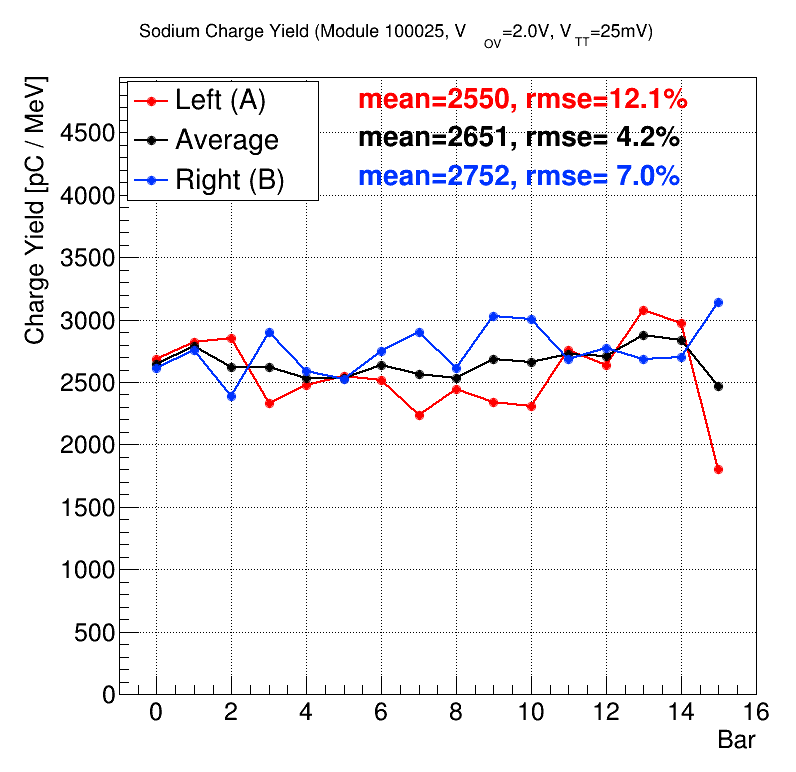

In [41]:
plot_LY(modules_AA, "100025", "ly_src") #third argument should be one of ly_spe, ly_src, or ly_pe

## Compute Calibration Info

In [18]:
module_Name_List = ["100025", "100026", "200041", "200042A", "200042B"]
module_Name_List2 = ["100025", "100026", "200041", "200042"]
SiPMs = ['100025A', '100025B', '100026A','100026B','200041A','200041B', '200042A','200042B']

### First, we'll ensure that if we rotate the module, the ratio between the pairs of readout channels (i.e. (Ch0, Ch31), (Ch1, Ch30), and so forth) does not change from module to module

In [19]:
#generate pairs of channels:
channel_pairs = []
for channel in range(32):
    channel_pairs.append((channel, 31-channel))
print(channel_pairs)

[(0, 31), (1, 30), (2, 29), (3, 28), (4, 27), (5, 26), (6, 25), (7, 24), (8, 23), (9, 22), (10, 21), (11, 20), (12, 19), (13, 18), (14, 17), (15, 16), (16, 15), (17, 14), (18, 13), (19, 12), (20, 11), (21, 10), (22, 9), (23, 8), (24, 7), (25, 6), (26, 5), (27, 4), (28, 3), (29, 2), (30, 1), (31, 0)]


In [20]:
ratioList =  []
LY_Ratio_Dict = {}
#let's look at SPE first
for ly_name in ["ly_spe", "ly_src", "ly_pe"]:
    LY_Ratio_Dict[ly_name] = {}
    for module_Name in module_Name_List:
        normal_orientation = get_LY_Array(modules_AA, module_Name, ly_name)
        reversed_orientation = get_LY_Array(modules_AB, module_Name, ly_name)
        normal_orientation_byChannel, reversed_orientation_byChannel = np.concatenate((normal_orientation[0][:,0],normal_orientation[2][:,0])), np.concatenate((reversed_orientation[0][:,0],reversed_orientation[2][:,0]))
        temp_ratio_list=  []
        for channel_pair in channel_pairs:
            temp_ratio_list.append(normal_orientation_byChannel[channel_pair[0]]/reversed_orientation_byChannel[channel_pair[1]])
        LY_Ratio_Dict[ly_name][module_Name] = list(temp_ratio_list)
    LY_Ratio_Dict[ly_name]["200042"] = np.concatenate((LY_Ratio_Dict[ly_name]["200042A"][:16], LY_Ratio_Dict[ly_name]["200042B"][16:]))


100025
Retrieving lye_spe
100025
Retrieving lye_spe
100026
Retrieving lye_spe
100026
Retrieving lye_spe
200041
Retrieving lye_spe
200041
Retrieving lye_spe
200042A
Retrieving lye_spe
200042A
Retrieving lye_spe
200042B
Retrieving lye_spe
200042B
Retrieving lye_spe
100025
100025
100026
100026
200041
200041
200042A
200042A
200042B
200042B
100025
100025
100026
100026
200041
200041
200042A
200042A
200042B
200042B


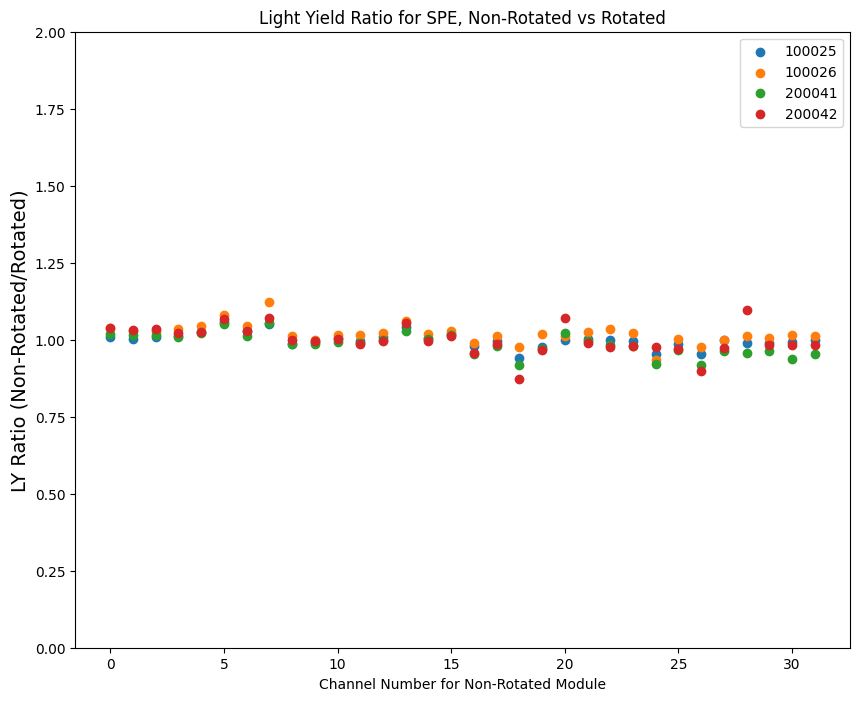

In [21]:
channel_pairs_strs = [str(channel_pair) for channel_pair in channel_pairs]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
for moduleName in module_Name_List2:
    plt.scatter(range(32), LY_Ratio_Dict["ly_spe"][moduleName], label=moduleName)
plt.title("Light Yield Ratio for SPE, Non-Rotated vs Rotated")
plt.xlabel("Channel Number for Non-Rotated Module")
plt.ylabel("LY Ratio (Non-Rotated/Rotated)", fontsize=14)
plt.legend()
plt.ylim(0,2)
plt.savefig(PLOT_DIR+"LY_Ratio_SPE.png")


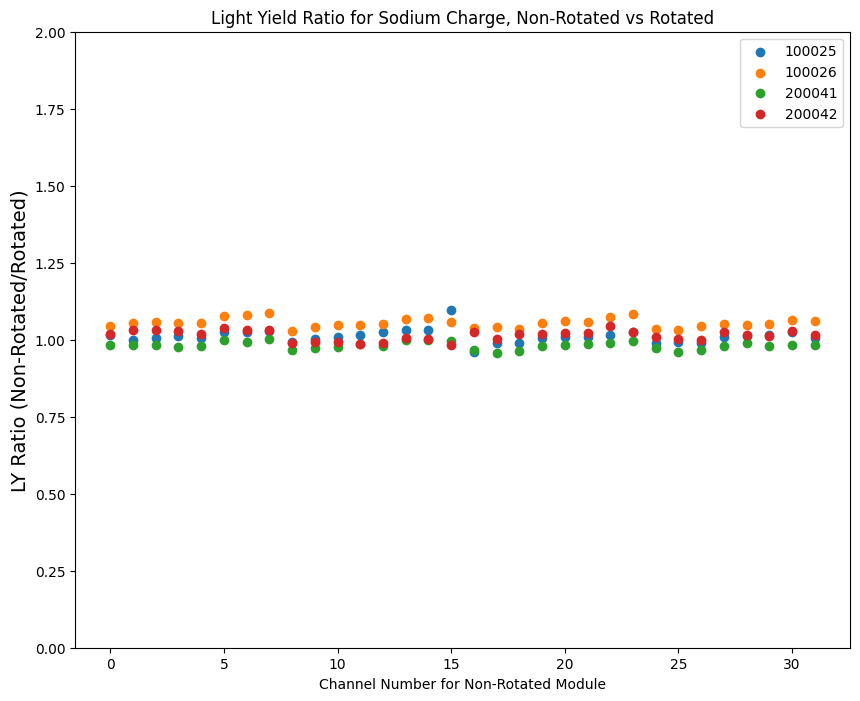

In [22]:
channel_pairs_strs = [str(channel_pair) for channel_pair in channel_pairs]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
for moduleName in module_Name_List2:
    plt.scatter(range(32), LY_Ratio_Dict["ly_src"][moduleName], label=moduleName)
plt.title("Light Yield Ratio for Sodium Charge, Non-Rotated vs Rotated")
plt.xlabel("Channel Number for Non-Rotated Module")
plt.ylabel("LY Ratio (Non-Rotated/Rotated)", fontsize=14)
plt.legend()
plt.ylim(0,2)
plt.savefig(PLOT_DIR+"LY_Ratio_SRC.png")


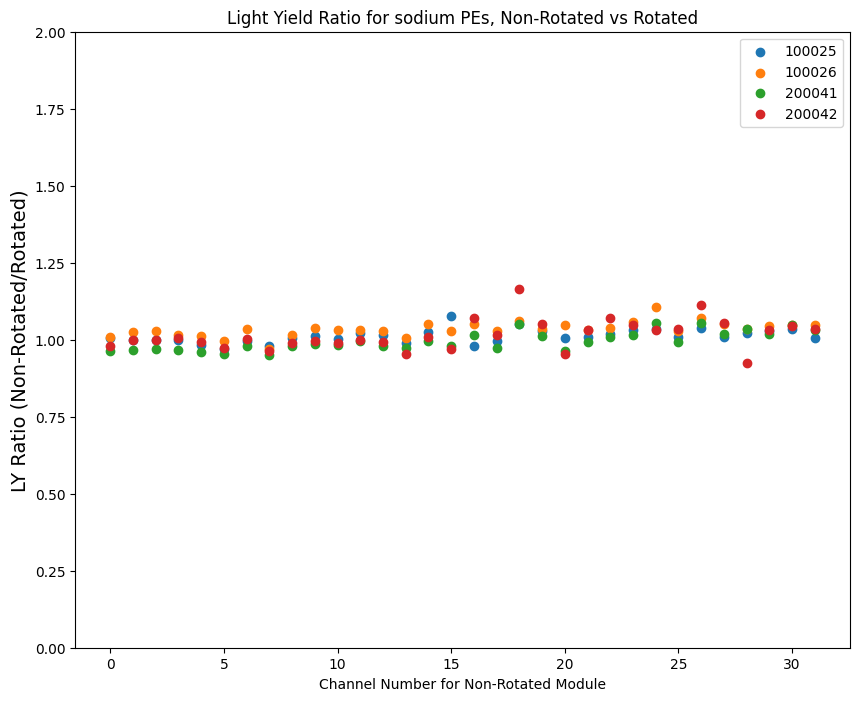

In [23]:
channel_pairs_strs = [str(channel_pair) for channel_pair in channel_pairs]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
for moduleName in module_Name_List2:
    plt.scatter(range(32), LY_Ratio_Dict["ly_pe"][moduleName], label=moduleName)
plt.title("Light Yield Ratio for sodium PEs, Non-Rotated vs Rotated")
plt.xlabel("Channel Number for Non-Rotated Module")
plt.ylabel("LY Ratio (Non-Rotated/Rotated)", fontsize=14)
plt.legend()
plt.ylim(0,2)
plt.savefig(PLOT_DIR+"LY_Ratio_PE.png")


### Proceeding with the actual calibration
#### Since each SiPM may have different technology, I'll compute the average on a SiPM by SiPM basis, as we do not expect that
#### the light yields will be the same (this prevents us from doing a global average). To find the final SPE calibration scalings, I'll average over the scalings from individual SiPMs I'll do it for SPEs first, then with that calibration. I also will only average over the side charge so that I don't have to account for fluctuations in temperature, etc
#### I'll repeat the same procedure for sodium charge. If both calibrations are done correctly, the PE LY should also be flat

### SPE Calibation

In [24]:
#first, obtain all LY measurements for SPE for each channel
#since we average over SiPM, for a given average, I'll have to combine data from the normal and rotated orientations
#for the letters, the first letter refers to which SiPM (i.e. 'A' SiPM glued to left side of the module when the sticker is near the bottom)
#the second letter is which set of channels that SiPM is being read-out by (A is Ch0-15)
SPE_LY_bySiPM = {}
#modules = ['100026', '200041', '200042A', '200042B']
sides = ['A', 'B']
for module_Name in module_Name_List:
    normal_orientation = get_LY_Array(modules_AA, module_Name, "ly_spe")
    reversed_orientation = get_LY_Array(modules_AB, module_Name, "ly_spe")    
    if module_Name == '200042A':
        SPE_LY_bySiPM[module_Name+'A'] = normal_orientation[0][:,0]
        SPE_LY_bySiPM[module_Name+'B'] = reversed_orientation[2][:,0]
        continue
    if module_Name == '200042B':
        SPE_LY_bySiPM[module_Name+'A'] = reversed_orientation[0][:,0]
        SPE_LY_bySiPM[module_Name+'B'] = normal_orientation[2][:,0]
        continue
    SPE_LY_bySiPM[module_Name+'AA'] = normal_orientation[0][:,0]
    SPE_LY_bySiPM[module_Name+'AB'] = reversed_orientation[2][:,0]
    SPE_LY_bySiPM[module_Name+'BA'] = reversed_orientation[0][:,0]
    SPE_LY_bySiPM[module_Name+'BB'] = normal_orientation[2][:,0]

100025
Retrieving lye_spe
100025
Retrieving lye_spe
100026
Retrieving lye_spe
100026
Retrieving lye_spe
200041
Retrieving lye_spe
200041
Retrieving lye_spe
200042A
Retrieving lye_spe
200042A
Retrieving lye_spe
200042B
Retrieving lye_spe
200042B
Retrieving lye_spe


In [25]:
#Now we can determine the calibration factors on a SiPM-by-SiPM basis
calibrationValues_bySiPM_SPE = []; errors_bySiPM_SPE = []
for key, value in SPE_LY_bySiPM.items():
    SiPM_avg = np.mean(value); SiPM_std = np.std(value)
    calibrationValues_bySiPM_SPE.append((value/SiPM_avg)**(-1))
calibrationValues_bySiPM_SPE_side = np.array(calibrationValues_bySiPM_SPE)
calibrationValues_bySiPM_SPE = []
for num in range(0,len(calibrationValues_bySiPM_SPE_side),2):
    calibrationValues_bySiPM_SPE.append(np.concatenate((calibrationValues_bySiPM_SPE_side[num,:], calibrationValues_bySiPM_SPE_side[num+1,:])))
calibrationValues_bySiPM_SPE = np.array(calibrationValues_bySiPM_SPE)

In [26]:
SiPM_calibration_SPE = np.average(calibrationValues_bySiPM_SPE, axis=0)

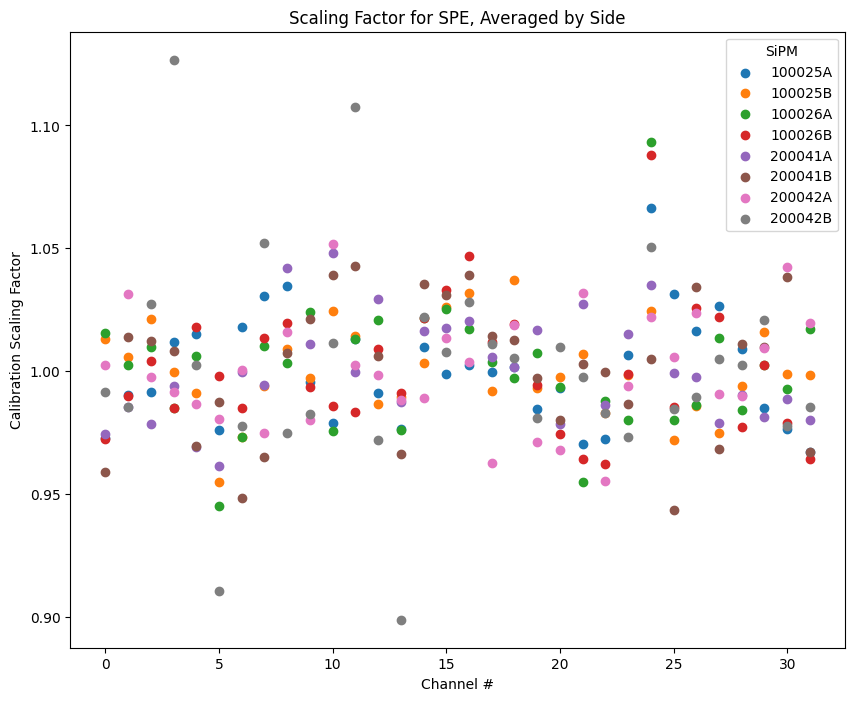

In [27]:
#plotting SPE calibration values on a SiPM-by-SiPM basis
plt.figure(figsize=(10,8))
for num, SiPM in enumerate(SiPMs):
    plt.scatter(np.arange(32), calibrationValues_bySiPM_SPE[num,:], label = SiPM[:len(SiPM)])
plt.title("Scaling Factor for SPE, Averaged by Side")
plt.xlabel("Channel #")
plt.ylabel("Calibration Scaling Factor")
plt.legend(title="SiPM")
plt.savefig(PLOT_DIR+"spe_scaling_factors_pre-average.png")

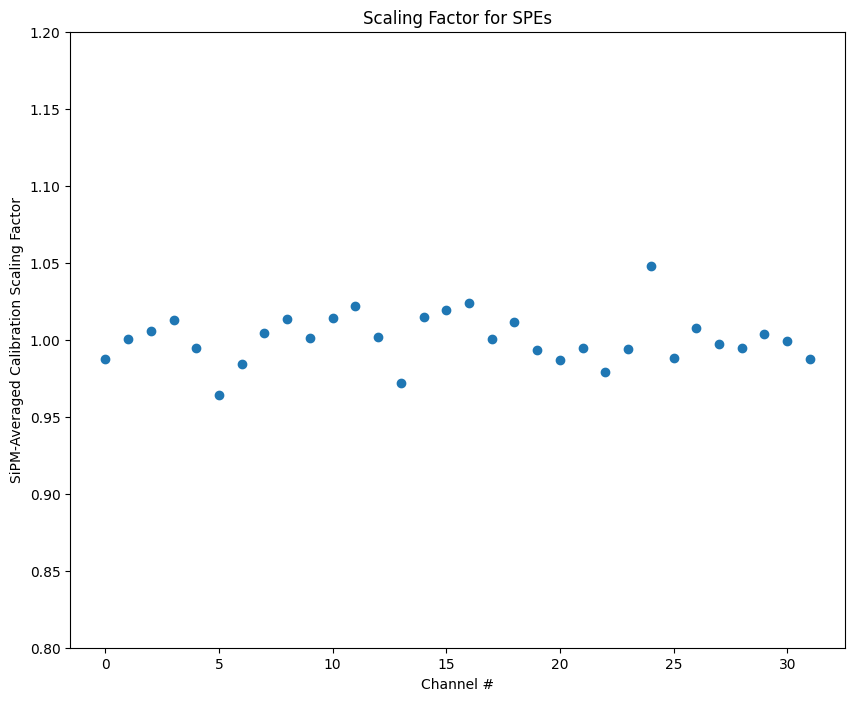

In [28]:
plt.figure(figsize=(10,8))
plt.scatter(np.arange(32), SiPM_calibration_SPE)
plt.title("Scaling Factor for SPEs")
plt.xlabel("Channel #")
plt.ylabel("SiPM-Averaged Calibration Scaling Factor")
plt.ylim(0.8,1.2)
plt.savefig(PLOT_DIR+"spe_scaling_factors.png")

### SRC Calibration

In [29]:
#repeat the process for the integrated sodium charge
# we need to exclude the channels affected by the gluing issue in Modules 100025 & 100026

nan_array = np.empty(5); nan_array[:] = np.nan
nan_array_single = np.empty(1); nan_array[:] = np.nan
SRC_LY_bySiPM = {}
sides = ['A', 'B']
for module_Name in module_Name_List:
    normal_orientation = get_LY_Array(modules_AA, module_Name, "ly_src")
    reversed_orientation = get_LY_Array(modules_AB, module_Name, "ly_src")    
    if module_Name == '200042A':
        SRC_LY_bySiPM[module_Name+'A'] = normal_orientation[0][:,0]
        SRC_LY_bySiPM[module_Name+'B'] = reversed_orientation[2][:,0]
        continue
    if module_Name == '200042B':
        SRC_LY_bySiPM[module_Name+'A'] = reversed_orientation[0][:,0]
        SRC_LY_bySiPM[module_Name+'B'] = normal_orientation[2][:,0]
        continue
    if module_Name == '100026': #mask out glue issues
        SRC_LY_bySiPM[module_Name+'AA']=np.concatenate((normal_orientation[0][:11,0],nan_array))
        SRC_LY_bySiPM[module_Name+'AB'] = np.concatenate((nan_array, reversed_orientation[2][5:,0]))
        SRC_LY_bySiPM[module_Name+'BA'] = np.concatenate((nan_array, reversed_orientation[0][5:,0]))
        SRC_LY_bySiPM[module_Name+'BB'] = np.concatenate((normal_orientation[2][:11,0], nan_array))
        continue
    if module_Name == '100025': #mask out glue issues
        SRC_LY_bySiPM[module_Name+'AA']=np.concatenate((normal_orientation[0][:15,0],nan_array_single))
        SRC_LY_bySiPM[module_Name+'AB'] = np.concatenate((nan_array_single, reversed_orientation[2][1:,0]))
        SRC_LY_bySiPM[module_Name+'BA'] = np.concatenate((nan_array_single, reversed_orientation[0][1:,0]))
        SRC_LY_bySiPM[module_Name+'BB'] = np.concatenate((normal_orientation[2][:15,0], nan_array_single))
        continue
    SRC_LY_bySiPM[module_Name+'AA'] = normal_orientation[0][:,0]
    SRC_LY_bySiPM[module_Name+'AB'] = reversed_orientation[2][:,0]
    SRC_LY_bySiPM[module_Name+'BA'] = reversed_orientation[0][:,0]
    SRC_LY_bySiPM[module_Name+'BB'] = normal_orientation[2][:,0]

100025
100025
100026
100026
200041
200041
200042A
200042A
200042B
200042B


In [30]:
#Now we can determine the calibration factors on a SiPM-by-SiPM basis
calibrationValues_bySiPM_SRC = []; errors_bySiPM_SRC = []
for key, value in SRC_LY_bySiPM.items():
    SiPM_avg = np.nanmean(value); SiPM_std = np.nanstd(value)
    calibrationValues_bySiPM_SRC.append((value/SiPM_avg)**(-1))
calibrationValues_bySiPM_SRC_side = np.array(calibrationValues_bySiPM_SRC)
calibrationValues_bySiPM_SRC = []
for num in range(0,len(calibrationValues_bySiPM_SRC_side),2):
    calibrationValues_bySiPM_SRC.append(np.concatenate((calibrationValues_bySiPM_SRC_side[num,:], calibrationValues_bySiPM_SRC_side[num+1,:])))
calibrationValues_bySiPM_SRC = np.array(calibrationValues_bySiPM_SRC)

In [31]:
SiPM_calibration_SRC = np.nanmean(calibrationValues_bySiPM_SRC, axis=0)

In [32]:
#temporarily replace nans for plotting (after averaging)
calibrationValues_bySiPM_SRC[np.isnan(calibrationValues_bySiPM_SRC)] = 0

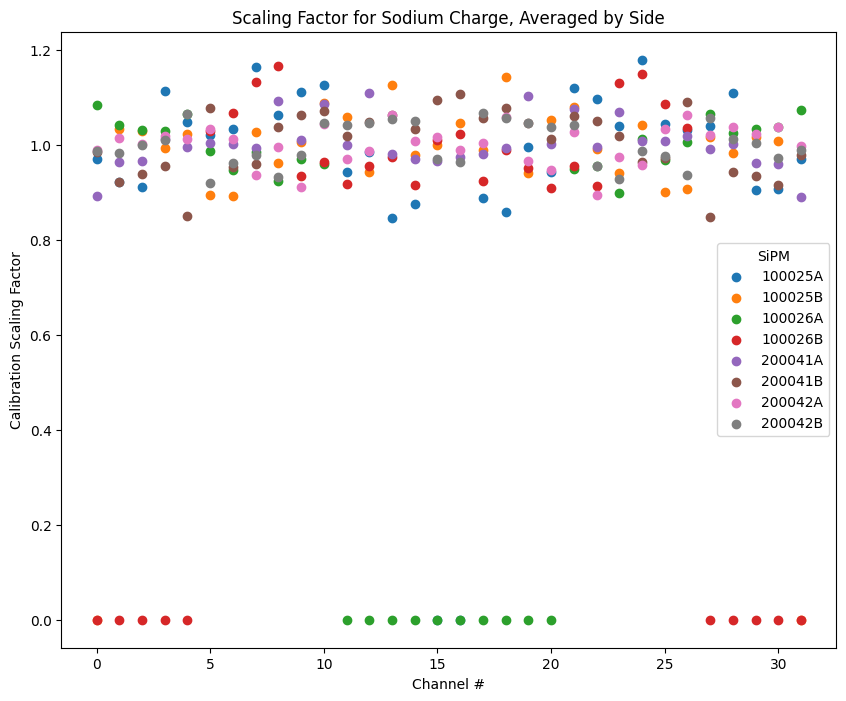

In [33]:
#plotting SPE calibration values on a SiPM-by-SiPM basis
plt.figure(figsize=(10,8))
for num, SiPM in enumerate(SiPMs):
    plt.scatter(np.arange(32), calibrationValues_bySiPM_SRC[num,:], label = SiPM)
plt.title("Scaling Factor for Sodium Charge, Averaged by Side")
plt.xlabel("Channel #")
plt.ylabel("Calibration Scaling Factor")
plt.legend(title="SiPM")
plt.savefig(PLOT_DIR+"sodium_scaling_factors_pre-average.png")

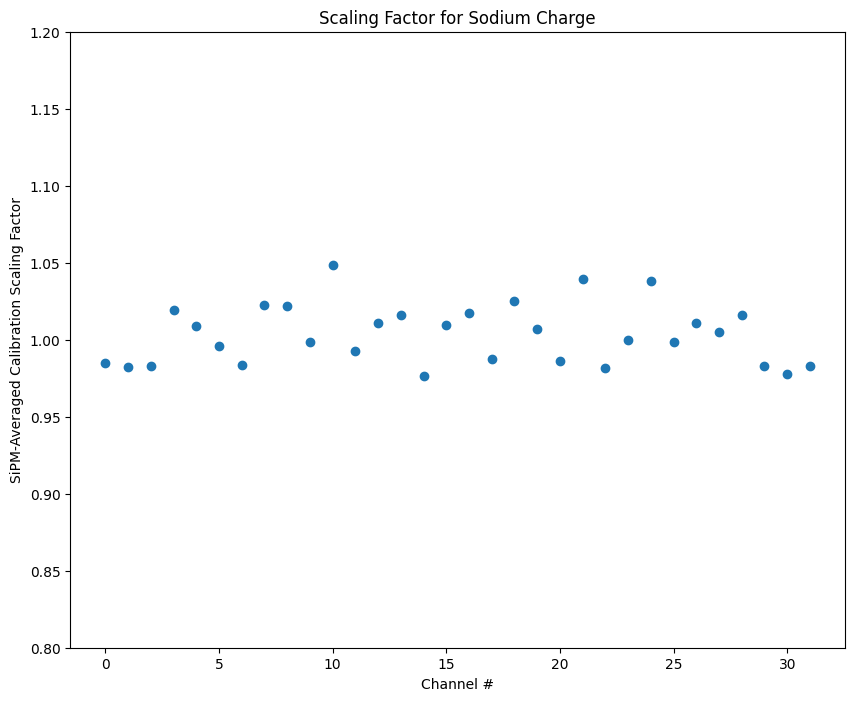

In [34]:
plt.figure(figsize=(10,8))
plt.scatter(np.arange(32), SiPM_calibration_SRC)
plt.title("Scaling Factor for Sodium Charge")
plt.xlabel("Channel #")
plt.ylabel("SiPM-Averaged Calibration Scaling Factor")
plt.ylim(0.8,1.2)
plt.savefig(PLOT_DIR+"sodium_scaling_factors.png")

### Compute Total Calibration (for PEs, this is just the ratio of the SRC scaling to the SPE scaling

In [35]:
SiPM_calibration_PE = SiPM_calibration_SRC/SiPM_calibration_SPE

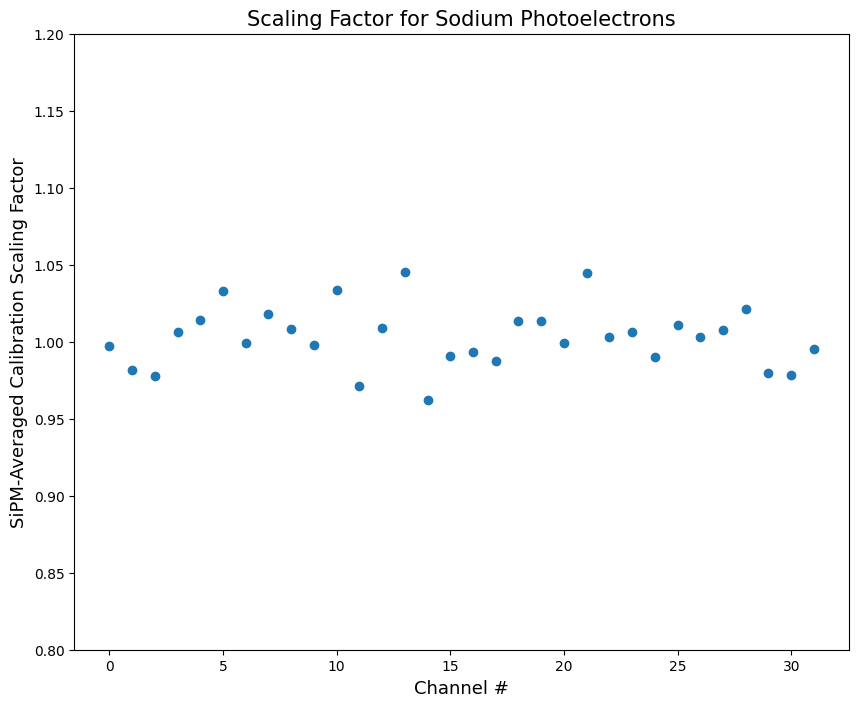

In [36]:
plt.figure(figsize=(10,8))
plt.scatter(np.arange(32), SiPM_calibration_PE)
plt.title("Scaling Factor for Sodium Photoelectrons", fontsize=15)
plt.xlabel("Channel #", fontsize=13)
plt.ylabel("SiPM-Averaged Calibration Scaling Factor", fontsize=13)
plt.ylim(0.8,1.2)
plt.savefig(PLOT_DIR+"sodium_pe_scaling_factors.png")

In [44]:
#the last step is to store and save the calibration values in a CSV
calibration_dict = {}

field_names = ["calibration_type"]
field_names.extend([f'ch{channel_num}' for channel_num in range(32)])

spe_list = ["spe"]
spe_list.extend(SiPM_calibration_SPE)
src_list = ["src"]
src_list.extend(SiPM_calibration_SRC)
pe_list = ["pe"]
pe_list.extend(SiPM_calibration_PE)

data = [field_names, spe_list, src_list, pe_list]

filename = PLOT_DIR+"jig_calibration_4modules.csv"
 
# writing to csv file
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerows(data)